In [11]:
!pip install seaborn
import pandas as pd
import numpy as np
import os
import requests

API_KEY = "YOUR_ALPHA_VANTAGE_API_KEY"

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

files = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv"
}

data = {}
for key, file in files.items():
    file_path = os.path.join(data_folder, file)
    if os.path.exists(file_path):
        data[key] = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")
    else:
        print(f"Warning: {file} not found. Skipping...")

def fetch_alpha_vantage_data(url, filename, date_col="date"):
    file_path = os.path.join(data_folder, filename)
    if os.path.exists(file_path):
        print(f"{filename} already exists.")
        return pd.read_csv(file_path, parse_dates=[date_col], index_col=date_col)

    print(f"Fetching {filename}...")
    response = requests.get(url)
    data_json = response.json()

    print("Alpha Vantage response:", data_json)

    if "Time Series (Daily)" in data_json:
        series = data_json["Time Series (Daily)"]
        df = pd.DataFrame.from_dict(series, orient="index")
        df.index = pd.to_datetime(df.index)
        df = df.rename(columns=lambda x: x.split(". ")[-1])
        df = df[["close"]].astype(float)
    elif "data" in data_json:
        df = pd.DataFrame(data_json["data"])
        df[date_col] = pd.to_datetime(df[date_col])
        df.set_index(date_col, inplace=True)
    else:
        raise ValueError("Unexpected data format from Alpha Vantage")

    df.sort_index(inplace=True)
    df.to_csv(file_path)
    return df

# Fetch oil
oil_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=WTI&apikey={API_KEY}"
try:
    oil_data = fetch_alpha_vantage_data(oil_url, "oil.csv", date_col="timestamp")
    print("Oil data columns:", oil_data.columns)

    # Normalize column names to lowercase for consistent access
    oil_data.columns = [col.lower() for col in oil_data.columns]

    if "close" in oil_data.columns:
        oil_data.rename(columns={"close": "oil_price"}, inplace=True)
        data["oil"] = oil_data[["oil_price"]]
    else:
        print("Warning: 'close' column not found in oil data. Skipping oil.")
except Exception as e:
    print("Error fetching oil data:", e)


# Merge all
df = data["sp500"][['close']].rename(columns={"close": "sp500_Close"})
for key in ["bitcoin", "gold"]:
    df = df.join(data[key][['Close']].rename(columns={"Close": f"{key}_Close"}), how="left")
for key in ["treasury_3m", "treasury_10y"]:
    df = df.join(data[key], how="left")
for key in ["oil"]:
    if key in data:
        df = df.join(data[key], how="left")

df.dropna(inplace=True)

# Save merged data
df.to_csv("data/merged_data.csv")
print("Merged data saved to data/merged_data.csv")


Defaulting to user installation because normal site-packages is not writeable
oil.csv already exists.
Oil data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Merged data saved to data/merged_data.csv


Columns in DataFrame: ['sp500_Close', 'bitcoin_Close', 'gold_Close', 'treasury_3m', 'treasury_10y', 'oil_price']
✅ 'oil_price' column found.
Oil price sample:
timestamp
2022-01-03    54.83
2022-01-04    55.59
2022-01-05    55.43
2022-01-06    56.89
2022-01-07    56.67
Name: oil_price, dtype: float64
Missing oil values: 0


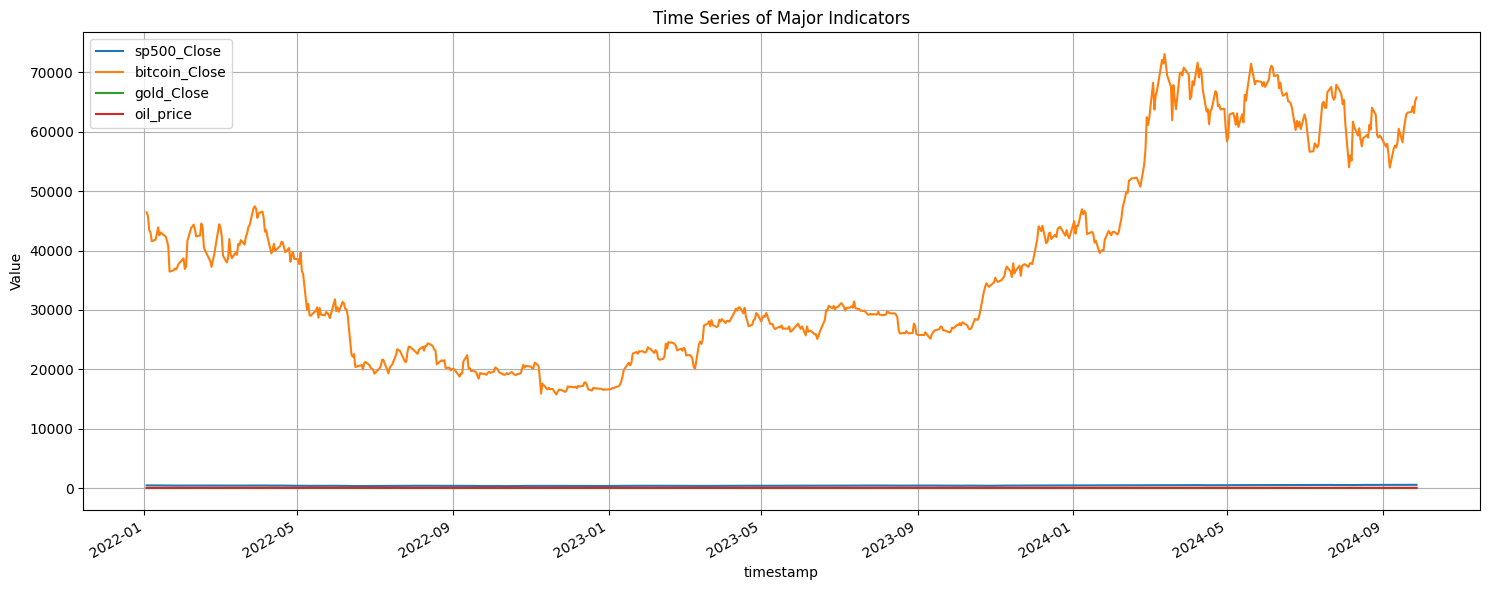

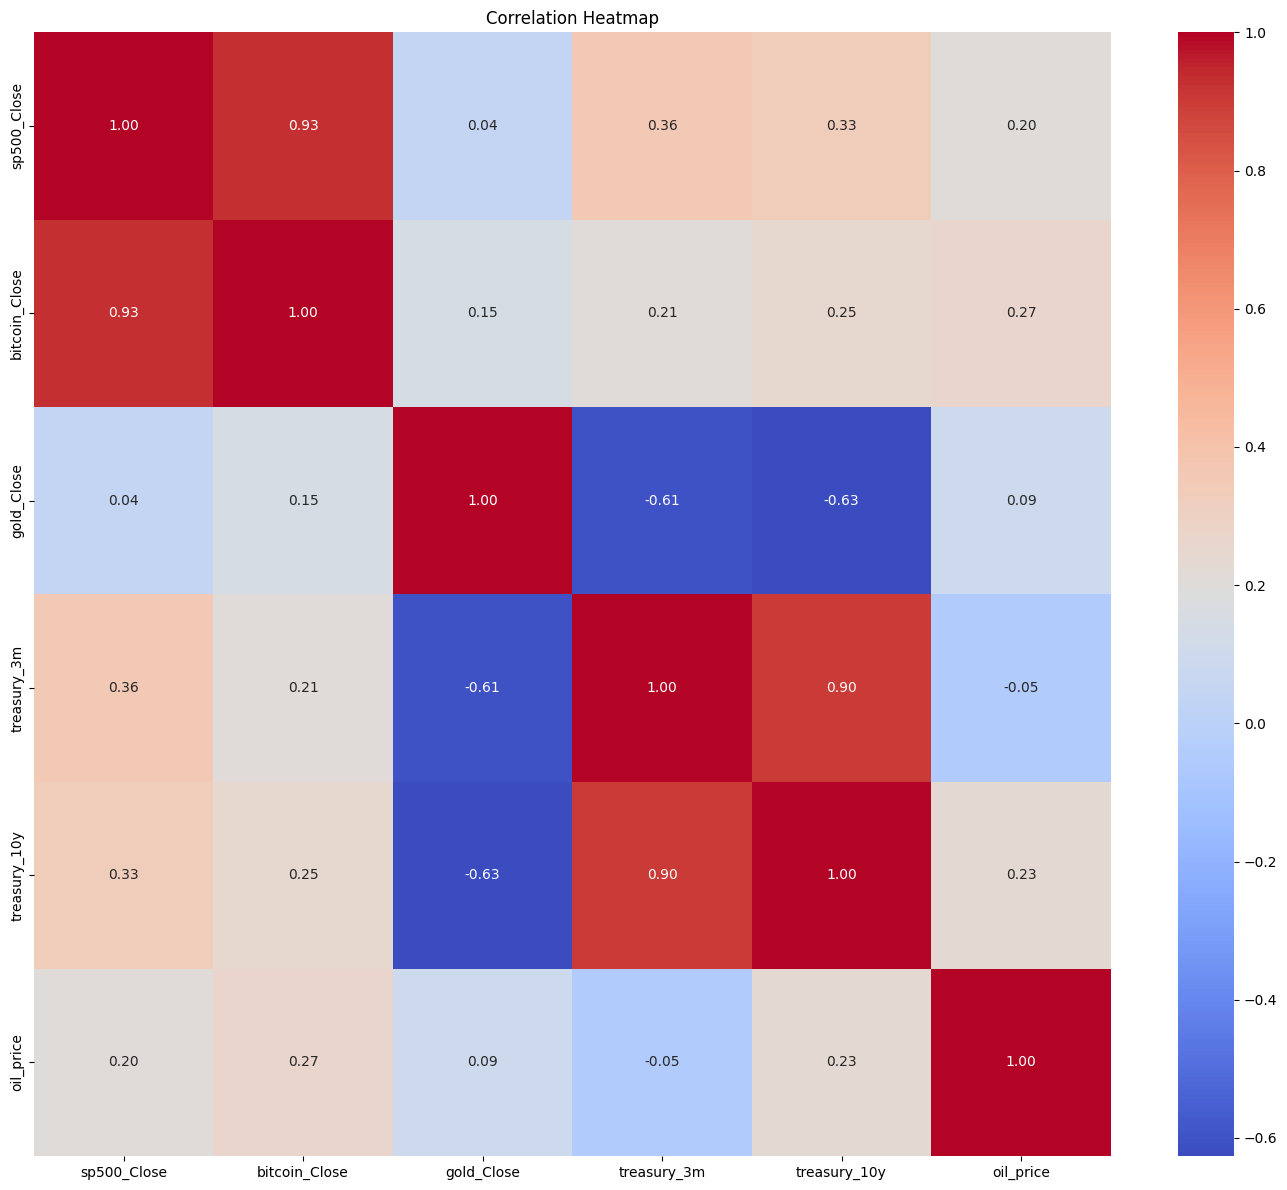

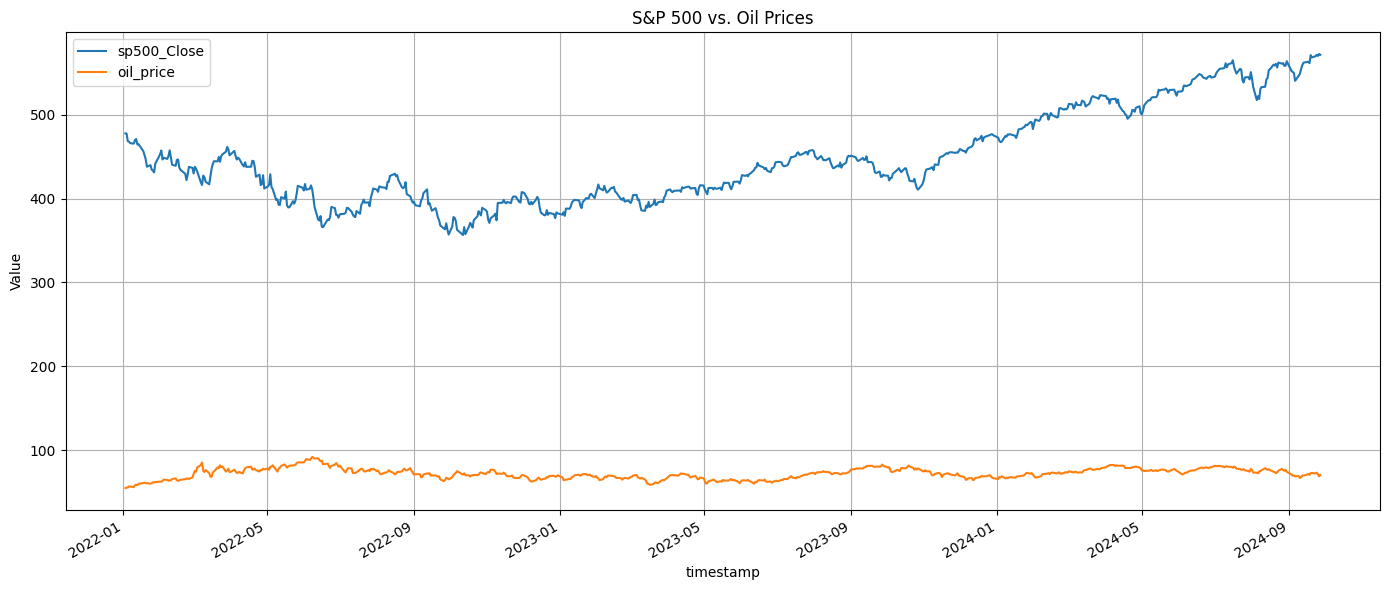

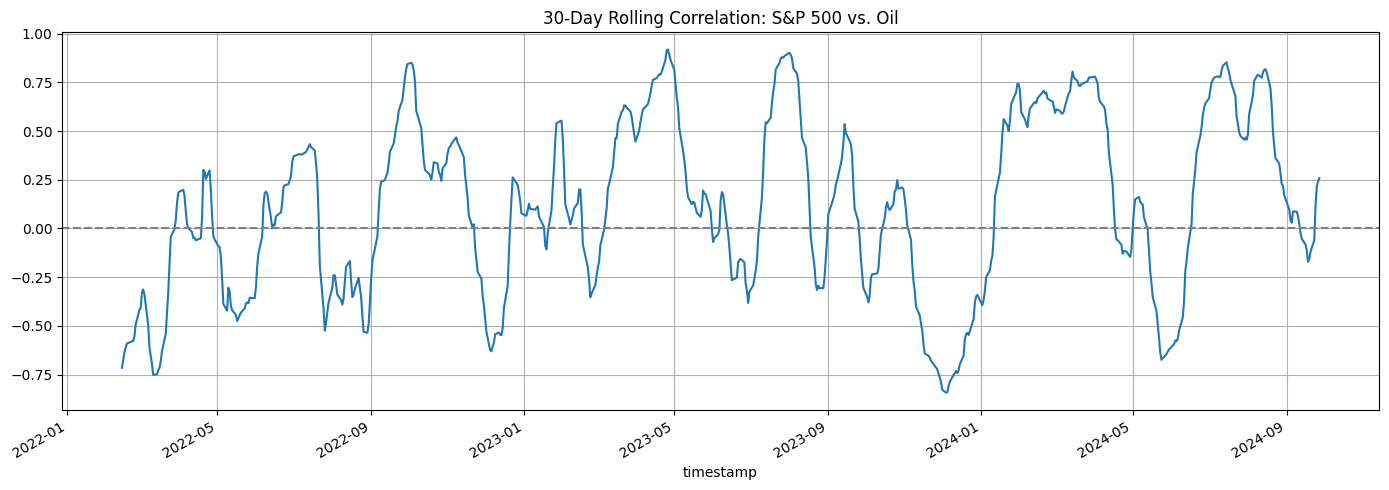

Correlation between oil and S&P 500 7 days later: 0.18
Correlation between oil and S&P 500 30 days later: 0.16


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
df = pd.read_csv("data/merged_data.csv", parse_dates=["timestamp"], index_col="timestamp")

# Clean and prepare the data
df = df.apply(pd.to_numeric, errors="coerce")
df.dropna(inplace=True)

# ✅ Check for oil_price column and its values
print("Columns in DataFrame:", df.columns.tolist())

if "oil_price" in df.columns:
    print("✅ 'oil_price' column found.")
    print("Oil price sample:")
    print(df["oil_price"].head())
    print("Missing oil values:", df["oil_price"].isna().sum())
else:
    print("⚠️ 'oil_price' column not found in DataFrame.")

# Time series plot of all indicators
plot_columns = [col for col in ["sp500_Close", "bitcoin_Close", "gold_Close", "oil_price"] if col in df.columns]
df[plot_columns].plot(figsize=(15, 6))
plt.title("Time Series of Major Indicators")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Oil vs. S&P 500 plot
if "sp500_Close" in df.columns and "oil_price" in df.columns:
    df[["sp500_Close", "oil_price"]].plot(figsize=(14, 6))
    plt.title("S&P 500 vs. Oil Prices")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 30-day rolling correlation between S&P 500 and Oil
if "sp500_Close" in df.columns and "oil_price" in df.columns:
    rolling_corr = df["sp500_Close"].rolling(window=30).corr(df["oil_price"])
    rolling_corr.plot(figsize=(14, 5))
    plt.title("30-Day Rolling Correlation: S&P 500 vs. Oil")
    plt.axhline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Correlation between oil and future S&P 500
lags = [7, 30]
for lag in lags:
    df[f"sp500_future_{lag}d"] = df["sp500_Close"].shift(-lag)
    lagged_corr = df[["oil_price", f"sp500_future_{lag}d"]].corr().iloc[0, 1]
    print(f"Correlation between oil and S&P 500 {lag} days later: {lagged_corr:.2f}")